# Requirement

For each customer (customer_id), H&M want a prediction of up to 12 products (article_ids), which is the predicted items a customer will buy in the next 7-day period after the training time period. The file should contain a header and have the following format.

In [1]:
import pandas as pd
import numpy as np

#used during data exploration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#handling missing values where not dropped
from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

from IPython.display import display, clear_output

# Get the Data

In [2]:
#get transaction data
transactions_train_df = pd.read_csv("data/transactions_train.csv") # import the transactions dataset

In [3]:
#get product meta data
articles_df = pd.read_csv("data/articles.csv")

In [4]:
#get customer meta data
customers_df = pd.read_csv("data/customers.csv")

# Prepare the Transaction Dataset

In [5]:
#first we will drop the sales channel as it will not be needed
transactions_train_df = transactions_train_df.drop(['sales_channel_id'], axis=1)

In [6]:
#we then convert our date text into a panda date type.
transactions_train_df["t_dat"] = pd.to_datetime(transactions_train_df["t_dat"])

In [7]:
#now we split out the date into seperate columns for day, month and year making use of python zip for memory efficiency
days, months, years  = zip(*[(d.day, d.month, d.year) for d in transactions_train_df['t_dat']])
transactions_train_df = transactions_train_df.assign(day=days, month=months, year=years)

In [8]:
#we drop the t_dat column as it is no longer needed
transactions_train_df = transactions_train_df.drop(['t_dat'], axis=1)

In [9]:
#we convert articles to string instead of default int.
transactions_train_df['article_id'] = transactions_train_df['article_id'].values.astype(str)

In [10]:
#we now reorganise the dataset to treat articles as the predictor
transactions_train_df = transactions_train_df[['article_id', 'year', 'month', 'day', 'price', 'customer_id']]

In [11]:
#we set articles column to index
transactions_train_df.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
663713001,2018,9,20,0.050831,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
541518023,2018,9,20,0.030492,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
505221004,2018,9,20,0.015237,00007d2de826758b65a93dd24ce629ed66842531df6699...
685687003,2018,9,20,0.016932,00007d2de826758b65a93dd24ce629ed66842531df6699...
685687004,2018,9,20,0.016932,00007d2de826758b65a93dd24ce629ed66842531df6699...
...,...,...,...,...,...
929511001,2020,9,22,0.059305,fff2282977442e327b45d8c89afde25617d00124d0f999...
891322004,2020,9,22,0.042356,fff2282977442e327b45d8c89afde25617d00124d0f999...
918325001,2020,9,22,0.043203,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...


In [12]:
# we want to see distributions and std dev
transactions_train_df.describe()

,year,month,day,price
count,3.178832e+07,3.178832e+07,3.178832e+07,3.178832e+07
mean,2.019207e+03,6.511067e+00,1.624134e+01,2.782927e-02
std,6.644412e-01,3.273328e+00,8.934254e+00,1.918113e-02
min,2.018000e+03,1.000000e+00,1.000000e+00,1.694915e-05
25%,2.019000e+03,4.000000e+00,8.000000e+00,1.581356e-02
50%,2.019000e+03,6.000000e+00,1.700000e+01,2.540678e-02
75%,2.020000e+03,9.000000e+00,2.400000e+01,3.388136e-02
max,2.020000e+03,1.200000e+01,3.100000e+01,5.915254e-01


# Prepare Customer Dataset

H&M are expecting about 1,371,980 prediction rows, we will only have 1,362,281 because 9,699 customers have not purchased anything yet.

Originally we were going to generate a list of missing customers, determine their demographics and match to those who have made transactions then use their values to fill the missing. This however was computationally expensive.

In [13]:
customers_df['customer_id'].size

1371980

In [14]:
cus_pred_df = transactions_train_df.groupby(transactions_train_df.customer_id)[['day','price']].median()

In [15]:
cus_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362281 entries, 00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 to ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   day     1362281 non-null  float64
 1   price   1362281 non-null  float64
dtypes: float64(2)
memory usage: 31.2+ MB


In [16]:
cus_pred_df['day'].size #we set articles column to index

1362281

In [17]:
cus_pred_df['customer_id'] = cus_pred_df.index

In [18]:
cus_pred_df = cus_pred_df.reset_index(drop=True)

In [19]:
cus_pred_df = cus_pred_df[['customer_id', 'day', 'price']]

In [20]:
cus_pred_df.head()

,customer_id,day,price
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,25.0,0.030492
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,21.0,0.025407
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18.0,0.033881
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,9.0,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,9.0,0.033881


In [21]:
non_transaction_customers_df = customers_df[~customers_df['customer_id'].isin(cus_pred_df['customer_id'])]

In [22]:
non_transaction_customers_df['day'] = 0

C:\Users\newlo\AppData\Local\Temp\ipykernel_9076\3592874415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_transaction_customers_df['day'] = 0


In [23]:
non_transaction_customers_df['price'] = 0.0

C:\Users\newlo\AppData\Local\Temp\ipykernel_9076\2901366215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_transaction_customers_df['price'] = 0.0


In [24]:
non_transaction_customers_df = non_transaction_customers_df.drop(['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'], axis=1)

#we now reorganise the dataset to treat articles as the predictor
non_transaction_customers_df = non_transaction_customers_df[['customer_id', 'day', 'price']]

In [25]:
non_transaction_customers_df['customer_id'].size

9699

In [26]:
non_transaction_customers_df = non_transaction_customers_df.reset_index(drop=True)

In [27]:
non_transaction_customers_df.head()

,customer_id,day,price
0,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...,0,0.0
1,000df4d2084d142416b8165bdd249bab8fea2393447aed...,0,0.0
2,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...,0,0.0
3,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...,0,0.0
4,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...,0,0.0


In [28]:
cus_pred_df = cus_pred_df.append(non_transaction_customers_df)

C:\Users\newlo\AppData\Local\Temp\ipykernel_9076\935700407.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cus_pred_df = cus_pred_df.append(non_transaction_customers_df)


In [29]:
cus_pred_df.tail()

,customer_id,day,price
9694,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...,0.0,0.0
9695,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...,0.0,0.0
9696,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,0.0,0.0
9697,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,0.0,0.0
9698,ffff01710b4f0d558ff62d7dc00f0641065b37e840bb43...,0.0,0.0


In [30]:
#we set articles column to index
cus_pred_df.set_index('customer_id')

,day,price
customer_id,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,25.0,0.030492
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,21.0,0.025407
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,18.0,0.033881
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,9.0,0.030492
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,9.0,0.033881
...,...,...
ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6f471e773a29a27a3d0,0.0,0.000000
ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c434a0debd1902c386a,0.0,0.000000
fff456fa60aac9174456c2f36ede5e0f25429a16c88a346dfb99333eb604cd6f,0.0,0.000000


## Check Missing Values

In [31]:
missing = cus_pred_df.isin([0]).sum(axis=1)
print(cus_pred_df.shape)
print(missing)

(1371980, 3)
0       0
1       0
2       0
3       0
4       0
       ..
9694    2
9695    2
9696    2
9697    2
9698    2
Length: 1371980, dtype: int64


## Fix Missing / Zero Values

In [32]:
cus_pred_df['day'] = cus_pred_df['day'].replace(0, cus_pred_df['day'].median())

In [33]:
cus_pred_df['price'] = cus_pred_df['price'].replace(0, cus_pred_df['price'].median())

In [34]:
missing = cus_pred_df.isin([0]).sum(axis=1)
print(cus_pred_df.shape)
print(missing)

(1371980, 3)
0       0
1       0
2       0
3       0
4       0
       ..
9694    0
9695    0
9696    0
9697    0
9698    0
Length: 1371980, dtype: int64


In [35]:
cus_pred_df.tail()

,customer_id,day,price
9694,ffe5801cb2a5b51d4d068322d7f8082e995f427a6f22a6...,17.0,0.025407
9695,ffeb3ca867aba57a312fe9d28d67dd46ef2240fe92a94c...,17.0,0.025407
9696,fff456fa60aac9174456c2f36ede5e0f25429a16c88a34...,17.0,0.025407
9697,fffa8d3cea26d4f5186472b923629b35fa28051f258030...,17.0,0.025407
9698,ffff01710b4f0d558ff62d7dc00f0641065b37e840bb43...,17.0,0.025407


# Explore Sample Transaction Data
We will create a sample from the transactions dataset to inspect relationships and test predictions. We split our sample data into a future test sample and a past training sample

In [36]:
ts_train_df = transactions_train_df.query('year == 2020 & month == 8').sample(n = 30) 

In [37]:
ts_test_df = transactions_train_df.query('year == 2020 & month == 9').sample(n = 30)

In [38]:
ts_train_df['article_id'].size

30

In [39]:
ts_train_df.head()

,article_id,year,month,day,price,customer_id
30597041,890197001,2020,8,21,0.031169,fd2cd02e61c364e08a8a7542acc0213cff348df5e6fcb5...
30094609,855080001,2020,8,8,0.025407,5b63aeb990f337a5fe21f1774c253457f16f00d9fa84d2...
30629014,857163001,2020,8,22,0.013542,e64506aa808cf8cc2073cf8a78c078d1a2ea39e8caa62e...
30866147,762846008,2020,8,28,0.025407,c7bbcd546ec7e1d368739e96bd45905a7dd7624e1d07c1...
30716869,910132001,2020,8,25,0.016932,548be1a518dcfb9eb589661202ef5de3758f7d92acf6ba...


In [42]:
#customer id too long for graph (000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318)
#we will use articles

#we set articles column to index
ts_train_df.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
890197001,2020,8,21,0.031169,fd2cd02e61c364e08a8a7542acc0213cff348df5e6fcb5...
855080001,2020,8,8,0.025407,5b63aeb990f337a5fe21f1774c253457f16f00d9fa84d2...
857163001,2020,8,22,0.013542,e64506aa808cf8cc2073cf8a78c078d1a2ea39e8caa62e...
762846008,2020,8,28,0.025407,c7bbcd546ec7e1d368739e96bd45905a7dd7624e1d07c1...
910132001,2020,8,25,0.016932,548be1a518dcfb9eb589661202ef5de3758f7d92acf6ba...
883936001,2020,8,3,0.022864,8896c62b5dcca6d09a0fd75967f6f153fbba2fd12d1d3c...
770315005,2020,8,18,0.016932,0dd981f4184a110b7fd01bbc38c886d58395d4d46090c5...
756322004,2020,8,4,0.010153,45e03ba337f49df7b2885cf5fffbd46ed8b8ffbfc1342f...
897423001,2020,8,28,0.011390,9821fc99b6270530edeea9c1570d704693e0ce21eba6f6...


In [53]:
ts_test_df.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
864231002,2020,9,21,0.016932,f0ea957a32aad4a78175a1bb294b8c97b2755ea04953bd...
933989002,2020,9,16,0.042356,f1f13a2f6d32dd1aabe020361f37385e77dd69ca7295fa...
800881006,2020,9,7,0.067780,6d0f67ac5ba92eefd4a2f7cf2ff1a2971d1100ab069143...
852442003,2020,9,16,0.050831,75ed968329b85e803ccba18f266b36b66c0acf34290745...
871889001,2020,9,18,0.050831,990d7387d958f920db38304098347b7d6b1ca549704a6b...
852773001,2020,9,1,0.025407,af61bef05bb454568c9f2ad57d9a23e13dbe7e02aa64f6...
751471022,2020,9,20,0.025407,64661e48bb62cd63e6b4188765441dbc1588197062e54d...
768921001,2020,9,7,0.013542,7b317fbf19db8c34ef811e45a5dcf7a6ea422104d14e53...
859743006,2020,9,19,0.022017,9369073e654914854964b0b11beb4c8ca0e23c17b08002...


In [75]:
test_query = ts_test_df.iloc[:1]
test_query.set_index('article_id')

,year,month,day,price,customer_id
article_id,,,,,
864231002,2020,9,21,0.016932,f0ea957a32aad4a78175a1bb294b8c97b2755ea04953bd...


In [76]:
test_query['customer_id'].values in ts_train_df['customer_id'].values

False

In [77]:
# Store features as numpy array Xy
#names = ts_train_df.index
names = ts_train_df['article_id']

X = ts_train_df.values

X[1] # look at one of our feature values

array(['855080001', 2020, 8, 8, 0.0254067796610169,
       '5b63aeb990f337a5fe21f1774c253457f16f00d9fa84d242e1b0392e5d8baf3c'],
      dtype=object)

In [86]:
# we pretend we have a customer who bought something on day 7 for €3 (assuming 0.03*100)
q = test_query[['day','price', 'article_id']]
q.set_index('article_id')

,day,price
article_id,,
864231002,21,0.016932


In [108]:
[q.iloc[0][0], q.iloc[0][1]]

[21, 0.0169322033898305]

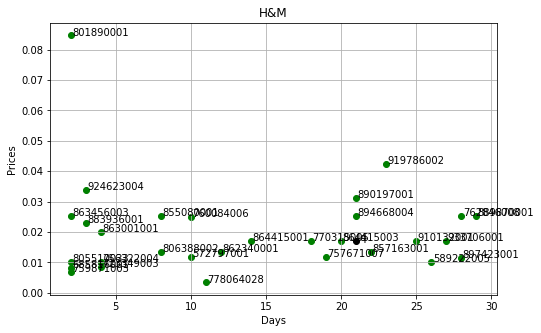

In [123]:
days = X[:,3] # x
prices = X[:,4] # y

q_days = q.iloc[0][0]
q_price = q.iloc[0][1]

#place day/price points on graph
plt.figure(figsize=(8,5))
plt.scatter(days, prices, color='green')

#place query on graph
plt.scatter(q_days, q_price,color='black')
plt.annotate('q',(q_days+0.2, q_price))

#label graph
plt.title("H&M")
plt.xlabel("Days")
plt.ylabel("Prices")

#display graph
plt.grid()

#populate product names on the graph
for i, txt in enumerate(names):
    plt.annotate(txt, (days[i]+0.09, prices[i]))

In [124]:
X[:,3:5]

array([[21, 0.0311694915254237],
       [8, 0.0254067796610169],
       [22, 0.0135423728813559],
       [28, 0.0254067796610169],
       [25, 0.0169322033898305],
       [3, 0.022864406779661],
       [18, 0.0169322033898305],
       [4, 0.0101525423728813],
       [28, 0.0113898305084745],
       [2, 0.0101525423728813],
       [12, 0.0135423728813559],
       [29, 0.0254067796610169],
       [2, 0.084728813559322],
       [10, 0.0118474576271186],
       [3, 0.0338813559322033],
       [2, 0.0254067796610169],
       [2, 0.0067627118644067],
       [4, 0.008457627118644],
       [2, 0.0081355932203389],
       [21, 0.0254067796610169],
       [23, 0.0423559322033898],
       [4, 0.0200508474576271],
       [11, 0.0033728813559322],
       [14, 0.0169322033898305],
       [27, 0.0169322033898305],
       [10, 0.0249999999999999],
       [19, 0.0118474576271186],
       [8, 0.0135423728813559],
       [20, 0.0169322033898305],
       [26, 0.0101525423728813]], dtype=object)

# Normalise the Sample Transaction Data

In [125]:
#we will use N(0,1) rescale with zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(X[:,3:5])  #need a handle on the scaler to apply to training and test data
X_scaled = scaler.transform(X[:,3:5])

In [126]:
q_scaled = scaler.transform([[q.iloc[0][0], q.iloc[0][1]]])

In [127]:
X_scaled

array([[ 0.77358021,  0.74365155],
       [-0.58541205,  0.35458478],
       [ 0.87811808, -0.44643505],
       [ 1.50534528,  0.35458478],
       [ 1.19173168, -0.21757224],
       [-1.10810138,  0.18293767],
       [ 0.45996661, -0.21757224],
       [-1.00356352, -0.67529786],
       [ 1.50534528, -0.59176293],
       [-1.21263925, -0.67529786],
       [-0.16726059, -0.44643505],
       [ 1.60988314,  0.35458478],
       [-1.21263925,  4.35968391],
       [-0.37633632, -0.56086645],
       [-1.10810138,  0.92674179],
       [-1.21263925,  0.35458478],
       [-1.21263925, -0.90416066],
       [-1.00356352, -0.78972926],
       [-1.21263925, -0.81147123],
       [ 0.77358021,  0.35458478],
       [ 0.98265594,  1.49889881],
       [-1.00356352, -0.00701846],
       [-0.27179845, -1.13302347],
       [ 0.04181515, -0.21757224],
       [ 1.40080741, -0.21757224],
       [-0.37633632,  0.32712124],
       [ 0.56450448, -0.56086645],
       [-0.58541205, -0.44643505],
       [ 0.66904235,

In [128]:
q_scaled

array([[ 0.77358021, -0.21757224]])

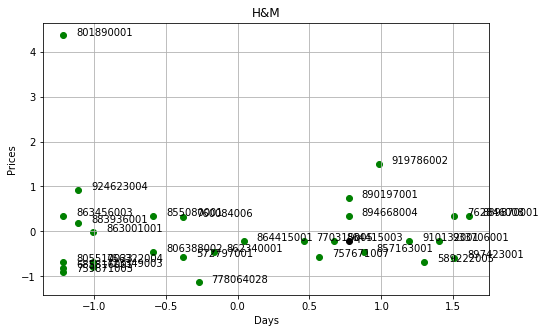

In [129]:
#check new scale
days = X_scaled[:,0] # x
prices = X_scaled[:,1] # y

plt.figure(figsize=(8,5))
plt.scatter(days, prices, color='green')

plt.scatter(q_scaled[:,0],q_scaled[:,1],color='black')
plt.annotate('q',(q_scaled[:, 0]+0.03,q_scaled[:, 1]))

plt.title("H&M")
plt.xlabel("Days")
plt.ylabel("Prices")
plt.grid()
#plt.legend(handles=[red_patch, blue_patch],loc=4)
for i, txt in enumerate(names):
    plt.annotate(txt, (days[i]+0.09, prices[i]))

# Train a KNN Model on Sample

In [130]:
knn_model = NearestNeighbors(n_neighbors=2, radius=0.4)
knn_model.fit(X_scaled)

NearestNeighbors(n_neighbors=2, radius=0.4)

# Predict with KNN Model

In [131]:
#get neighbours' names where k=12
result = knn_model.kneighbors(q_scaled, 12)[1][0]

In [132]:
# result contains the 'index' of the nearest neighbours
for n in result:
    p = names.iloc[n]
    item = articles_df.query('article_id == ' + str(p))
    print("PRODUCT: " + str(p))
    print(item.iloc[0][24])
    print(" ")

PRODUCT: 864415003
Thong briefs in lace with a low waist, lined gusset and string back.
 
PRODUCT: 857163001
Leggings in soft cotton jersey with a high elasticated waist.
 
PRODUCT: 770315005
Top in airy jersey crêpe with a V-neck, short cap sleeves and a small stand-up collar with gathers at the back of the neck.
 
PRODUCT: 757671007
Short-sleeved blouse in a viscose crêpe weave with a round neckline and small opening with a concealed button at the back of the neck. Decorative gathers at the shoulders and along the yoke at the back.
 
PRODUCT: 910132001
V-neck strappy tops in soft, organic cotton jersey, one ribbed.
 
PRODUCT: 894668004
5-pocket, ankle-length trousers in twill. Loose fit with a high waist, zip fly and button and gently tapered legs.
 
PRODUCT: 933706001
Blouse in sturdy cotton denim with buttons down the front and a wide, rounded collar with a small frill trim. Long sleeves with wide, buttoned cuffs, and a gently rounded hem. Slightly longer at the back. The cotton co

# Evaluate Model on Sample

In [ ]:
X_test_scaled = scaler.transform(test_query[:,3:5])

# Generate Predictions File

In [135]:
#H&M Collaborative KNN Model Based Recommendation System
def hm_rec_sys(r_model, cus_df, write_file):  
    
    #write_file = "ros_predictions.csv"
    with open(write_file, "wt", encoding="utf-8") as output:
        #add headers first
        output.write("customer_id,prediction" + '\n')
        
        #now we loop through each row and write predictions to csv file
        for index, cus in cus_df.iterrows():
            #select day and price and convert them to np array
            q_cus = np.array([cus['day'],cus['price']], dtype=float) #cus[3:5]
            
            #normalise data
            q_cus_scaled = scaler.transform([q_cus])

            #get neighbours' names where k=12
            result = r_model.kneighbors(q_cus_scaled, 12)[1][0]
            
            #create prediction csv file
            r = []
            r.append(cus.customer_id + ",")
            for n in result:
                p = names.iloc[n]
                r.append("0" + str(p))
                prediction =  ' '.join(r)
            #write predictions to csv file
            output.write(prediction + '\n')
            clear_output(wait=True)
            display('Processed Row: ' + str(index))

In [136]:
#we now generate our intial predictions list and save it as a csv file
hm_rec_sys(knn_model, cus_pred_df, "data/ros_predictions3.csv")

'Processed Row: 9698'

In [137]:
#inspect our prediction data
predictions_df = pd.read_csv("data/ros_predictions3.csv")

In [139]:
predictions_df.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,890197001 762846008 889870001 894668004 91978...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,894668004 890197001 864415003 770315005 91013...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,890197001 894668004 919786002 760084006 77031...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,855080001 760084006 924623004 863456003 88393...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,855080001 760084006 924623004 863456003 88393...


In [138]:
predictions_df['customer_id'].size

1371980